## Model training on Argoverse Data

In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import argparse

In [11]:
from utils.boxes import generate_anchors, xyxy_to_xywh, xywh_to_xyxy
from utils.boxes import compute_deltas, compute_overlaps, boxes_postprocess

In [12]:
from model.modules import deltas_to_boxes, compute_overlaps, safe_softmax
from utils.config import Config


In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [14]:
args = Config().parse()

training chunk_sizes: [20]
The results will be saved to  C:\Users\cathx\repos\squeezedet\SqueezeDet-PyTorch\exp\default


In [15]:
from demo import demo

In [16]:
args.arch = 'squeezedet'
args.gpus = [0]
# args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
args.device = 'cuda:0'
args.root_dir = ''
args.batch_size = 15
args.num_epochs = 200
args.no_eval = True    # default = True, we do not want to surpass mAP evaluation during training
args.load_model = '../models/squeezenet1_1-f364aa15.pth'
# args.data_dir = 'C://users/cathx/repos/squeezedet/squeezedet-pytorch/data/data_kitti/'

In [17]:
from train import train

In [18]:
train(args)

anchors                        [[   8.    8.   34.   30.]
 [   8.    8.   75.   45.]
 [   8.    8.   38.   90.]
 ...
 [1240.  376.  194.  178.]
 [1240.  376.  283.  156.]
 [1240.  376.  381.  185.]]
anchors_per_grid               9
arch                           squeezedet
batch_size                     15
bbox_loss_weight               6.0
chunk_sizes                    [20]
class_loss_weight              1.0
class_names                    ('VEHICLE', 'PEDESTRIAN')
data_dir                       C:\Users\cathx\repos\squeezedet\SqueezeDet-PyTorch\data
dataset                        kitti
debug                          0
debug_dir                      C:\Users\cathx\repos\squeezedet\SqueezeDet-PyTorch\exp\default\debug
device                         cuda:0
drift_prob                     1.0
dropout_prob                   0.5
exp_dir                        C:\Users\cathx\repos\squeezedet\SqueezeDet-PyTorch\exp
exp_id                         default
flip_prob                      0.5
forb

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\cathx\anaconda3\envs\tesla\lib\site-packages\torch\utils\data\_utils\worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\cathx\anaconda3\envs\tesla\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\cathx\anaconda3\envs\tesla\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\cathx\repos\squeezedet\SqueezeDet-PyTorch\src\datasets\base.py", line 24, in __getitem__
    image, image_meta, gt_boxes = self.preprocess(image, image_meta, gt_boxes)
  File "C:\Users\cathx\repos\squeezedet\SqueezeDet-PyTorch\src\datasets\base.py", line 52, in preprocess
    image, image_meta, boxes = drift(image, image_meta, prob=drift_prob, boxes=boxes)
  File "C:\Users\cathx\repos\squeezedet\SqueezeDet-PyTorch\src\utils\image.py", line 28, in drift
    max_boxes_y = min(boxes[:, 1]) if boxes is not None else max_drift_y
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed


In [24]:
import cv2
import matplotlib.pyplot as plt

In [20]:
kitti_i = 'C://users/cathx/repos/squeezedet/Squeezedet-pytorch/data/kitti_o/training/image_2/000001.png'

In [22]:
kitti = cv2.imread(kitti_i)

In [23]:
kitti.shape

(375, 1242, 3)

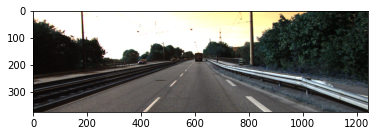

In [26]:
plt.imshow(kitti)

In [31]:
argo_i = 'C://users/cathx/repos/squeezedet/squeezedet-pytorch/data/kitti/training/image_2/000001.png'

In [32]:
argo = cv2.imread(argo_i)

In [33]:
argo.shape

(1200, 1920, 3)

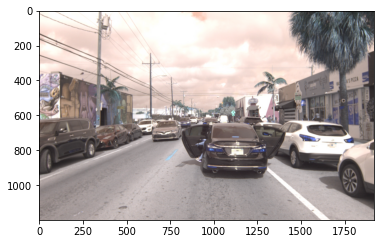

In [34]:
plt.imshow(argo)

## Preprocess the Argoverse data

1. Calculate the mean average and variance of the dataset.

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import skimage.io
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
root_dir = 'C://users/cathx/repos/squeezedet/squeezedet-pytorch/data/kitti/'

In [6]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, directory):
        super(DataSet, self).__init__()
        self.directory = directory
        self.data_dir = os.path.join(self.directory, 'image_sets/train.txt')
    def __len__(self):
        return len(open(self.data_dir).readlines())
    
    def __getitem__(self, index):
        
#                 sample_ids_path = os.path.join(self.data_dir, 'image_sets', sample_set_name)
        with open(self.data_dir, 'r') as fp:
            sample_ids = fp.readlines()
        sample_ids = tuple(x.strip() for x in sample_ids)
        image_id = sample_ids[index]
        image_path = os.path.join(self.directory, 'training/image_2/', image_id + '.png')
#         image, image_id = self.load_image(index)
        image = skimage.io.imread(image_path).astype(np.float32)
        return image
    

In [7]:
data = DataSet(root_dir)
data_loader = DataLoader(data)

In [ ]:
for batch_id, inputs in enumerate(data_loader):
    for i in range(10):
        print(inputs)

tensor([[[[239., 248., 255.],
          [239., 248., 255.],
          [239., 248., 255.],
          ...,
          [ 45.,  45.,  45.],
          [ 46.,  44.,  45.],
          [ 48.,  44.,  45.]],

         [[240., 249., 255.],
          [240., 249., 255.],
          [239., 248., 255.],
          ...,
          [ 45.,  45.,  43.],
          [ 47.,  46.,  44.],
          [ 49.,  45.,  44.]],

         [[240., 249., 255.],
          [240., 249., 255.],
          [239., 248., 255.],
          ...,
          [ 45.,  45.,  43.],
          [ 47.,  46.,  44.],
          [ 50.,  46.,  45.]],

         ...,

         [[142., 144., 156.],
          [141., 143., 155.],
          [141., 143., 155.],
          ...,
          [168., 170., 182.],
          [169., 171., 183.],
          [168., 170., 182.]],

         [[143., 145., 158.],
          [143., 145., 158.],
          [142., 144., 157.],
          ...,
          [170., 172., 184.],
          [169., 171., 183.],
          [168., 170., 182.]],



In [ ]:
class ARGO(DataSet):
    

In [56]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, directory):
#         self.data = data
        super(DataSet, self).__init__()
        self.directory = directory
        self.data_dir = os.path.join(directory, 'image_sets/train.txt')
#         print(self.data_dir)
        self.sample_ids, self.sample_ids_path = self.get_sample_ids(self.data_dir)
    
    def __len__(self):
        return len(self.directory)
    
    def __getitem__(self,index):
#         path = os.path.join(self.directory.iloc[index])
        image, image_id = self.load_image(index)
        return image, image_id
    
    def get_sample_ids(self, data_dir):
        sample_ids_path = data_dir
        with open(sample_ids_path, 'r') as fp:
            sample_ids = fp.readlines()
        sample_ids = tuple(x.strip() for x in sample_ids)
        
        return sample_ids, sample_ids_path
    
    def load_image(self, index):
        image_id = self.sample_ids[index]
        image_path = os.path.join(self.directory, 'training/image_2', image_id + '.png')
        image = skimage.io.imread(image_path).astype(np.float32)
        return image, image_id
    
    

AttributeError: module 'torch.utils.data' has no attribute 'DataSet'

In [51]:
data = DataSet(root_dir)

In [52]:
img_dataloader = DataLoader(data)

In [55]:
for batch_id, inputs in enumerate(img_dataloader):
    for i in range(10):
        image = cv2.imread(inputs[i])
        plt.imshow(image)

SystemError: <built-in function imread> returned NULL without setting an error

ValueError: axes don't match array

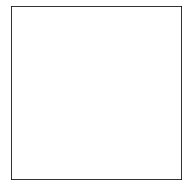

In [45]:
for batch_id, inputs in enumerate(img_dataloader):
    fig = plt.figure(figsize=(14,7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
        plt.imshow(np.array(inputs[i]).transpose(1,2,0))
    break